## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from generate_TF import GenerateTF

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorchClassifiers import Net


In [2]:
# Load the data
df = pd.read_pickle('./data/new-transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.001000,"[-1619443.35975, -1614550.781623867, -1609658....","[-22.318748715595078, -26.94110311858538, -27...."
1,-20.0,0.001088,"[-1619443.35975, -1614550.781623867, -1609658....","[-17.266355322587795, -24.53201635526134, -35...."
2,-20.0,0.001185,"[-1619443.35975, -1614550.781623867, -1609658....","[-16.7162220396677, -21.797706698181052, -21.7..."
3,-20.0,0.001289,"[-1619443.35975, -1614550.781623867, -1609658....","[-17.99189952290407, -21.15339387216752, -17.8..."
4,-20.0,0.001403,"[-1619443.35975, -1614550.781623867, -1609658....","[-14.184688148597308, -17.88658030869824, -22...."


In [3]:
phi_encoder = preprocessing.LabelEncoder()
phi_encoder.fit(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
gain_encoder.fit(df['g_oo'])
print(gain_encoder.classes_)


[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.001      0.0010884  0.00118461 0.00128933 0.0014033  0.00152735
 0.00166237 0.00180932 0.00196926 0.00214334 0.00233281 0.00253902
 0.00276347 0.00300776 0.00327364 0.00356302 0.00387799 0.00422079
 0.00459391 0.005     ]


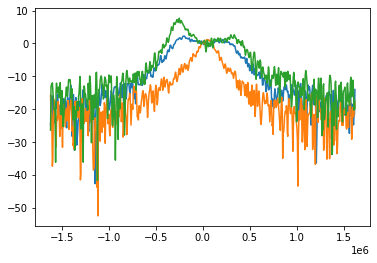

In [29]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [ ]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [32]:
for index, row in df.sample(n=300).iterrows():
    y = row['y']
    x = row['x']
    fig = plt.figure()
    plt.plot(x, y)
    title = f'phase{np.round(row["phi"], 2)}-gain{np.round(row["g_oo"], 4)}'
    plt.title(title)
    plt.ylim(-50, 50)
    plt.savefig(f'plots/generated_curves/{title}.jpg', transparent=False)
    plt.close()

In [5]:
values = np.zeros((len(df), len(df.loc[0, 'y'])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row['y']
    index += 1

data_scaler = preprocessing.StandardScaler().fit(values)


In [6]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = len(phi_encoder.classes_)
model1 = Net(n_inputs, n_outputs, name='phase_classifier', activation_func=F.gelu,
             hidden_1=500, hidden_2=200, hidden_3=0,
             avg_pool=(6, 6), trim_edges=135, verbose=1,
             with_batch_norm=True, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-135, -135), value=0)
  (pool1): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  (fc1): Linear(in_features=65, out_features=500, bias=True)
  (batch_norm1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (batch_norm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [7]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = len(gain_encoder.classes_)

model2 = Net(n_inputs, n_outputs, name='gain_classifier', activation_func=F.gelu,
             hidden_1=420, hidden_2=350, hidden_3=0,
             avg_pool=(4,4), trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [8]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load(optimizer=optimizer1, filename='models/new_phase_classifier-acc62.pt')
model2.load(optimizer=optimizer2, filename='models/new_gain_classifier-acc99.pt')


In [9]:
from generate_TF import GenerateTF
import torch
import torch.nn.functional as F


def curve_fit_deluxe(func, x, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        x, sample = x[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    x = torch.tensor(x).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    x = F.avg_pool1d(x, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, x, sample, **kwargs)


This region is to use gradio and visualize predictions

19.0 0.004593906051905874


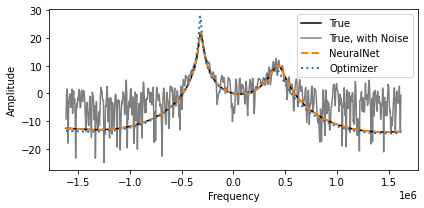

In [40]:

def classify(phase, gain, savefig=False):
    phase, gain = float(phase), float(gain)
    print(phase, gain)
    # table = PrettyTable()
    # table.field_names = ["param", "original", "model", "opt"]
    table = []
    gen_tf_noise = GenerateTF(fb_attn_index=3, with_noise=True)
    x = gen_tf_noise.frequency

    gen_tf_no_noise = GenerateTF(fb_attn_index=3, with_noise=False)

    # I get one input with given phase, gain from X_validate or y_validate
    y = gen_tf_noise(x, phase, gain)
    y_scaled = torch.tensor(data_scaler.transform([y]), dtype=torch.float32)

    phase_encoded = phi_encoder.transform([phase])
    gain_encoded = gain_encoder.transform([gain])

    # I make predictions with models + optimizer
    with torch.no_grad():
        model1.eval()
        model2.eval()
        pred_phase = model1(torch.atleast_2d(y_scaled))
        pred_gain = model2(torch.atleast_2d(y_scaled))

    # Extract top category
    _, pred_phase = torch.exp(pred_phase).topk(1, dim=1)
    _, pred_gain = torch.exp(pred_gain).topk(1, dim=1)

    # Get original value
    pred_phase = phi_encoder.inverse_transform(pred_phase.ravel().numpy())[0]
    pred_gain = gain_encoder.inverse_transform(pred_gain.ravel().numpy())[0]

    # Get optimizers results
    (opt_phase, opt_gain), _ = curve_fit_deluxe(gen_tf_no_noise, x, y, trim_edges=130,
                                                kernel_size=4, stride=1,
                                                bounds=([-20, 0.001], [20, 0.005]), method='trf')

    # I add them to the table
    table.append(['phase', float(np.round(phase, 2)), float(np.round(pred_phase, 2)), float(np.round(opt_phase, 2))])
    table.append(['gain', float(np.round(gain, 4)), float(np.round(pred_gain, 4)), float(np.round(opt_gain, 4))])

    # I plot them
    if savefig:
        fig = plt.figure(figsize=(6, 3))
    else:
        fig = plt.figure()
    p = plt.plot(x, gen_tf_no_noise(x, phase, gain), label=f'True', ls='-', color='black')
    plt.plot(x, gen_tf_noise(x, phase, gain), label=f'True, with Noise', ls='-', color='black', alpha=0.5)
    plt.plot(x, gen_tf_no_noise(x, pred_phase, pred_gain), label=f'NeuralNet',
             ls='--', color='tab:orange', lw=2)
    plt.plot(x, gen_tf_no_noise(x, opt_phase, opt_gain), label=f'Optimizer',
             ls=':', color='tab:blue', lw=2)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(f'plots/classifier_demo-phase{np.round(phase, 2)}-gain{np.round(gain, 2)}.png',
                    dpi=400)
    # print(table.get_string())
    return fig, table

fig, table = classify(19, gain_encoder.classes_[-2], savefig=True)
# fig.show()
# print(table)

# return: an array (with the predicted/ real values) + a figure with the ploted lines

In [11]:
import gradio as gr

# print(gain_encoder.classes_.astype(str).tolist())
# build the gradio interface
interface = gr.Interface(fn=classify,
                         inputs=[
                             gr.Slider(label=f'Phase', minimum=-20., maximum=20., step=1.),
                             gr.Dropdown(label='Gain', choices=gain_encoder.classes_.astype(str).tolist(),
                                         type="value"),
                             # gr.Dropdown(["KNN", "SoftMax", "KerasShallow", "KerasDeep"], label='Choose Model'),
                         ],
                         outputs=[
                             gr.Plot(label='Graphical Evaluation'),
                             # gr.Textbox(lines=5),
                             gr.DataFrame(label='Numerical Evaluation',
                                          headers=['Param', 'True', 'NeuralNet', 'Optimizer'],
                                          datatype=['str', 'number', 'number', 'number'],
                                          row_count=2, col_count=(4, 'fixed'))
                         ],
                         interpretation="default",
                         )

interface.launch(debug=False)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f12bf977610>, 'http://127.0.0.1:7860/', None)